In [1]:
! pip install shap
! pip install torch
! pip install pycountry_convert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Q1

In [2]:
import torch
import pandas as pd
from torch.autograd import Variable
import pycountry_convert as pc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from torch import nn
import torch.nn.functional as F
print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Is CUDA available True
Torch 2.0.0+cu118 CUDA 11.8
Device: cuda:0


In [3]:
def train_model(model,epochs,criterion,optimizer,data_loader):
    train_loss = 0
    correct = 0
    total = 0
    with tqdm(data_loader) as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            size = targets.size(0)
            total += size
            train_tqdm.set_postfix(loss=train_loss,total = total,refresh=True)
          
    return train_loss

In [4]:
def predict_labels(model,x_test,tensor=True):
  if(not tensor):
    x_test = torch.from_numpy(x_test)
  with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(x_test.cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(x_test)).data.numpy()
    
    return predicted

In [5]:
def country_to_continent(country_name):
    if(("Timor" in country_name) or ("Korea" in country_name)):
      return 'Asia'
    if(('Tanzania' in country_name) or ('Congo' in country_name)):
      return 'Africa'
    if('Macedonia' in country_name):
      return "Europe"
    if("(" in country_name):
      country_name = country_name[:country_name.index("(")].strip()
    if("Republic of" in country_name):
      country_name = country_name.replace("Republic of ","").replace("'","").strip()
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [6]:
def count_samples(data,mapping):
  df = pd.DataFrame()
  df['Country'] = data['Country'].copy()
  continents = ['Asia', 'Europe', 'Africa', 'North America', 'South America','Oceania']
  df['Continent'] = df['Country'].apply(lambda col : country_to_continent(mapping[col]))
  print("Country Count")
  for continent in continents:
    count = df[df['Continent']==continent]['Country'].unique()
    print(f"{continent} : {len(count)}")

In [28]:
data = pd.read_csv('Life Expectancy Data.csv')
categorical_feature_mask = data.dtypes==object
categorical_cols = data.columns[categorical_feature_mask].tolist()
numerical_cols = data.columns[~categorical_feature_mask].tolist()
numerical_cols.remove("Year")
data = data.dropna(subset=categorical_cols)
data[numerical_cols] = data[numerical_cols].apply(lambda x: x.fillna(x.mean()),axis=0)
numerical_cols.remove("Life expectancy ")
#data[numerical_cols]=(data[numerical_cols]-data[numerical_cols].min())/(data[numerical_cols].max()-data[numerical_cols].min())
le_coutry = LabelEncoder()
le_coutry.fit(data['Country'])
country_mapping = {i: l for i, l in enumerate(le_coutry.classes_)}
reverse_mapping = {l: i for i, l in enumerate(le_coutry.classes_)} 
le = LabelEncoder()
data[categorical_cols] = data[categorical_cols].apply(lambda col: le.fit_transform(col))

In [29]:
features = list(data.columns)
features.remove('Life expectancy ')
features.remove('Year')
Xdf_train, Xdf_test, ydf_train, ydf_test = train_test_split(data[features], data['Life expectancy '], test_size=0.1, random_state=42)

In [30]:
count_samples(Xdf_test,country_mapping)

Country Count
Asia : 37
Europe : 32
Africa : 44
North America : 18
South America : 10
Oceania : 8


In [218]:
from sklearn.preprocessing import StandardScaler
#scaling = StandardScaler()
scaling = MinMaxScaler()
X_train = scaling.fit_transform(Xdf_train.values.astype('float32'))
X_test = scaling.transform(Xdf_test.values.astype('float32'))
y_train = ydf_train.values.astype('float32').reshape(-1,1)
y_test = ydf_test.values.astype('float32').reshape(-1,1)

Xt_train = torch.from_numpy(X_train)
yt_train = torch.from_numpy(ydf_train.values.astype('float32').reshape(-1,1)) # data type is long

Xt_test = torch.from_numpy(X_test)
yt_test = torch.from_numpy(ydf_test.values.astype('float32').reshape(-1,1)) # data type is long

batch_size = 200
num_epochs = 500

train = torch.utils.data.TensorDataset(Xt_train, yt_train)
test = torch.utils.data.TensorDataset(Xt_test, yt_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [41]:
Xdf_train

,Country,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2752,181,1,84.0,1,1.73,292.402267,93.000000,0,55.1,1,94.0,4.50,93.0,0.1,3372.575170,1.275338e+07,5.1,4.9,0.831,13.2
2486,163,1,221.0,0,4.41,250.711237,80.940461,0,49.0,0,74.0,7.14,73.0,1.6,2232.513244,4.834400e+04,3.5,3.5,0.000,11.0
642,40,0,97.0,0,12.14,1884.098811,95.000000,0,63.1,0,95.0,7.80,95.0,0.1,13467.468270,4.238389e+06,1.5,1.5,0.820,15.1
1229,78,1,139.0,28,0.01,0.000000,95.000000,3,47.6,33,98.0,5.89,99.0,0.1,7483.158469,1.275338e+07,7.4,7.7,0.686,11.8
1583,100,1,67.0,46,1.10,3.885395,64.000000,92,14.8,75,79.0,4.82,64.0,24.7,29.979898,1.213711e+06,7.7,7.6,0.388,10.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,104,0,59.0,0,6.91,3601.287457,82.000000,3,68.0,0,96.0,9.60,96.0,0.1,22821.847000,4.162680e+05,0.8,0.7,0.826,14.8
1095,70,1,287.0,4,3.21,53.307827,83.000000,26,23.1,7,82.0,6.70,83.0,5.9,543.957418,1.555880e+05,8.0,7.9,0.405,8.9
1130,72,1,266.0,17,6.08,56.778587,80.940461,0,4.7,23,62.0,5.56,63.0,2.7,615.819819,9.556889e+06,4.2,4.2,0.458,8.4
1294,82,0,72.0,2,9.30,3519.258515,95.000000,10982,57.0,3,97.0,8.17,96.0,0.1,27387.225800,5.731323e+06,0.5,0.5,0.841,15.4


In [226]:
inputDim = len(features)
outputDim = 1     
learningRate = 0.001
model = nn.Sequential(
    nn.Linear(inputDim, 10),
    nn.Linear(10, 1),
)

if torch.cuda.is_available():
    print("found GPU")
    model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate,momentum = 0.8)

found GPU


In [267]:
train_model(model,num_epochs,criterion,optimizer,train_loader)

100%|██████████| 14/14 [00:00<00:00, 181.06it/s, loss=329, total=2644]


329.3764991760254

In [268]:
from sklearn.metrics import mean_squared_error
y_pred = predict_labels(model,Xt_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 4.680435


In [291]:
print(r2_score(y_test, y_pred))

0.7611590166286869


#### Kernel SHAP

In [277]:
import shap

  0%|          | 0/294 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


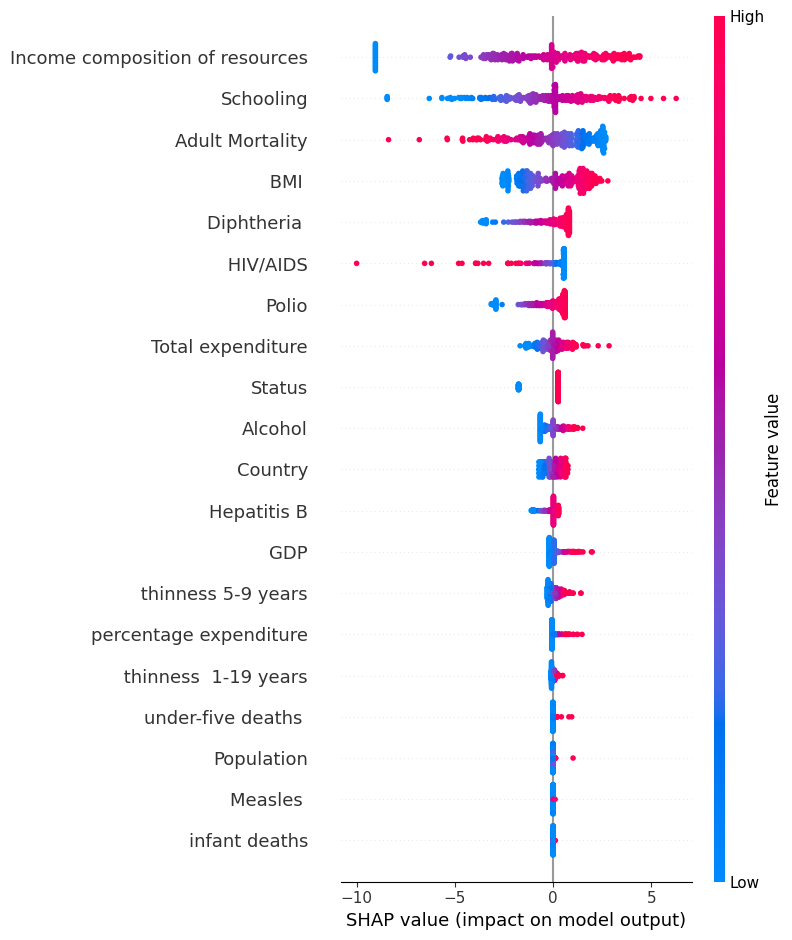

In [293]:
idx = np.random.randint(X_train.shape[0], size=200)
X_train_summary = X_train[idx,:]
ex = shap.KernelExplainer(lambda x: predict_labels(model,x,False).flatten(), X_train_summary)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names = features)

In [294]:
pakistan = Xdf_test[Xdf_test['Country'] == reverse_mapping['Pakistan']].sample(1)
iran = Xdf_test[Xdf_test['Country'] == reverse_mapping['Iran (Islamic Republic of)']].sample(1)
print("paskistan: ",ydf_test[pakistan.index[0]])
print("iran: ",ydf_test[iran.index[0]])

paskistan:  65.1
iran:  72.0


In [295]:
pakistan_x = scaling.transform(pakistan.values.astype('float32'))
iran_x = scaling.transform(iran.values.astype('float32'))
pakistan_shap_values = ex.shap_values(pakistan_x)
iran_shap_values = ex.shap_values(iran_x)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pakistan

In [296]:
shap.initjs()
shap.force_plot(ex.expected_value, pakistan_shap_values,pakistan.values,features)

iran

In [297]:
shap.initjs()
shap.force_plot(ex.expected_value, iran_shap_values,iran.values,features)

#### Deep Shap

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


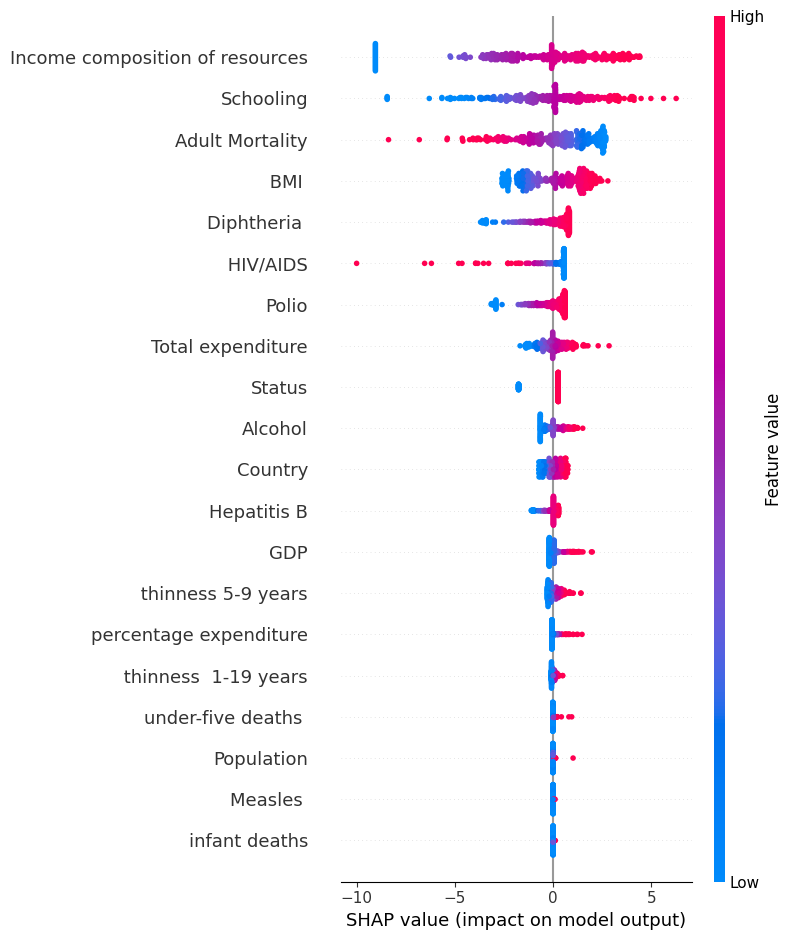

In [298]:
Deep_exp=shap.DeepExplainer(model, torch.from_numpy(X_train_summary).to(device))
Deep_shap_values = Deep_exp.shap_values(Xt_test)
shap.summary_plot(Deep_shap_values, X_test,feature_names = features)

In [299]:
pakistan_dshap_values = Deep_exp.shap_values(torch.from_numpy(pakistan_x))
iran_dshap_values = Deep_exp.shap_values(torch.from_numpy(iran_x))

pakistan

In [300]:
shap.initjs()
shap.force_plot(Deep_exp.expected_value, pakistan_dshap_values,pakistan.values,features)

iran

In [301]:
shap.initjs()
shap.force_plot(Deep_exp.expected_value,iran_dshap_values,iran.values,features)